## Proyecto Housing

![Boston](https://bostonagentmagazine.com/wp-content/uploads/2016/07/rsz_1south_boston_.jpg)

### Tratamiento de datos

Realizamos las importaciones de las librerías que necesitaremos

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from functions import nans, drop_nans, nans_row_index, nans_per_row
import altair as alt
import missingno as msno

In [19]:
sns.set(style='darkgrid')

In [20]:
dt_train = pd.read_csv('train.csv')
dt_test = pd.read_csv('test.csv')

Hay 81 columnas en el dataset, vamos a evaluar tanto % de nans, outliers, correlaciones...

In [21]:
dt_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

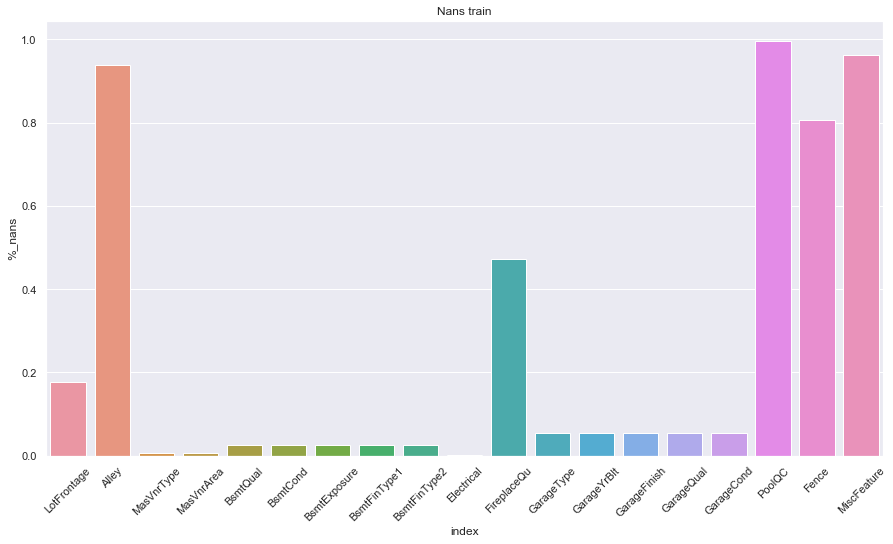

In [22]:
plt.figure(figsize=(15, 8))
sns.barplot(nans(dt_train)['index'], nans(dt_train)['%_nans'])
plt.xticks(rotation=45)
plt.title('Nans train')
plt.show()

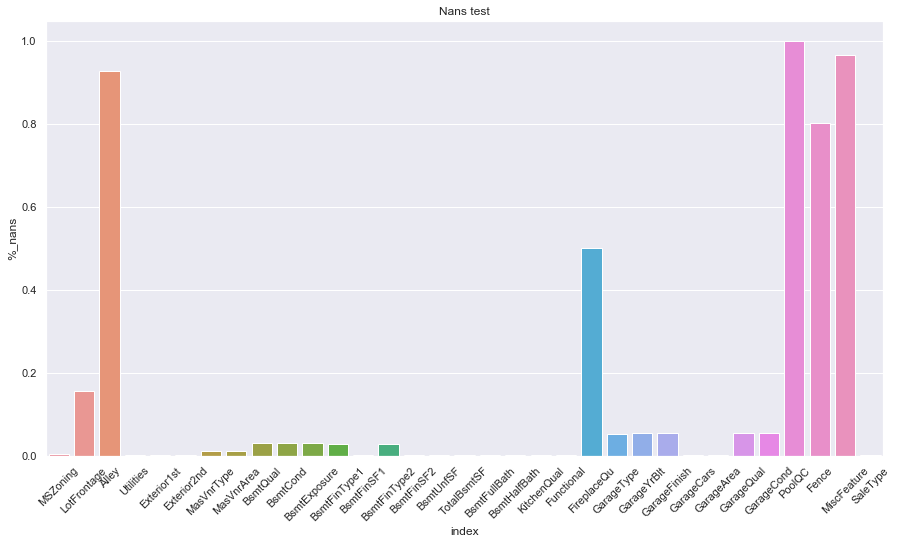

In [23]:
plt.figure(figsize=(15, 8))
sns.barplot(nans(dt_test)['index'], nans(dt_test)['%_nans'])
plt.xticks(rotation=45)
plt.title('Nans test')
plt.show()

La distribución de NaNs en el set de entrenamiento y el de test es muy similar.
Variables como 'Alley', 'PoolQC', 'Fence' o 'MiscFeature' tienen un % de nans muy alto.

Variables como 'Alley', 'PoolQC', 'Fence' o 'MiscFeature' tienen un % de nans muy alto

De acuerdo a la documentación, estas variables:
>```
Alley: Type of alley access to property
>
>       Grvl	Gravel
>       Pave	Paved
>       NA 	No alley access
>```

>```
PoolQC: Pool quality
>
>       Ex	Excellent
>       Gd	Good
>       TA	Average/Typical
>       Fa	Fair
>       NA	No Pool
>```

>```
Fence: Fence quality
>
>       GdPrv	Good Privacy
>       MnPrv	Minimum Privacy
>       GdWo	Good Wood
>       MnWw	Minimum Wood/Wire
>       NA	No Fence
>```

>```
MiscFeature: Miscellaneous feature not covered in other categories
>
>       Elev	Elevator
>       Gar2	2nd Garage (if not described in garage section)
>       Othr	Other
>       Shed	Shed (over 100 SF)
>       TenC	Tennis Court
>       NA	None
>```

Llenamos los NaN's de la variable Alley, Fence y Misc con una nueva categoría ('NO')

In [24]:
no = ['Alley', 'Fence', 'MiscFeature']
for i in no:
    dt_train[i].fillna('NO', inplace=True)
    dt_test[i].fillna('NO', inplace=True)

Mediante la función drop_nans vamos filtrar todas las variables con un % de NaNs superior al indicado
```python
def nans(df):
    nans = pd.DataFrame(df.isnull().sum(), columns=['num_nans'])
    nans.reset_index(inplace=True)
    nans['%_nans'] = nans['num_nans'] / len(df)
    return nans[nans['num_nans'] != 0]


def drop_nans(df, val):
    resume = nans(df)
    var_to_drop = list(resume['index'][resume['%_nans'] >= val])
    df = df.drop(var_to_drop, axis=1)
    return df
```


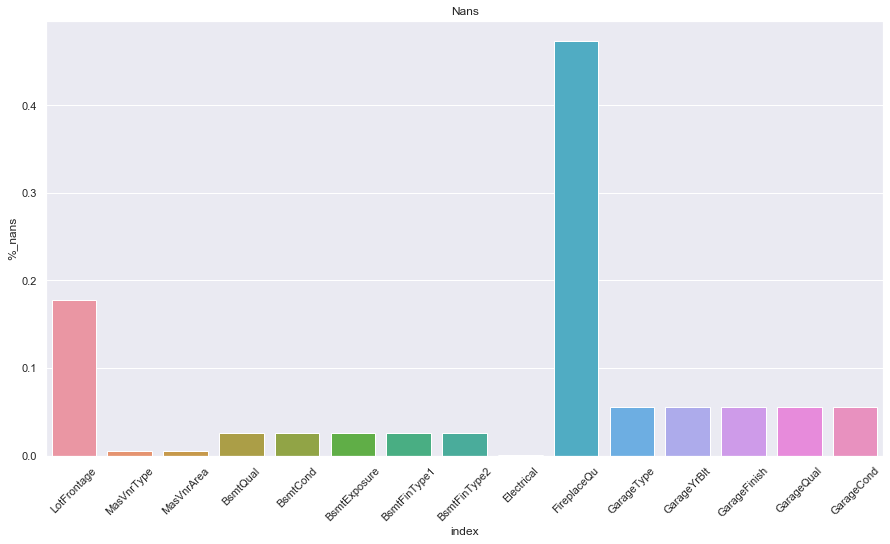

In [25]:
dt_train = drop_nans(dt_train, 0.5)
plt.figure(figsize=(15, 8))
sns.barplot(nans(dt_train)['index'], nans(dt_train)['%_nans'])
plt.xticks(rotation=45)
plt.title('Nans')
plt.show()

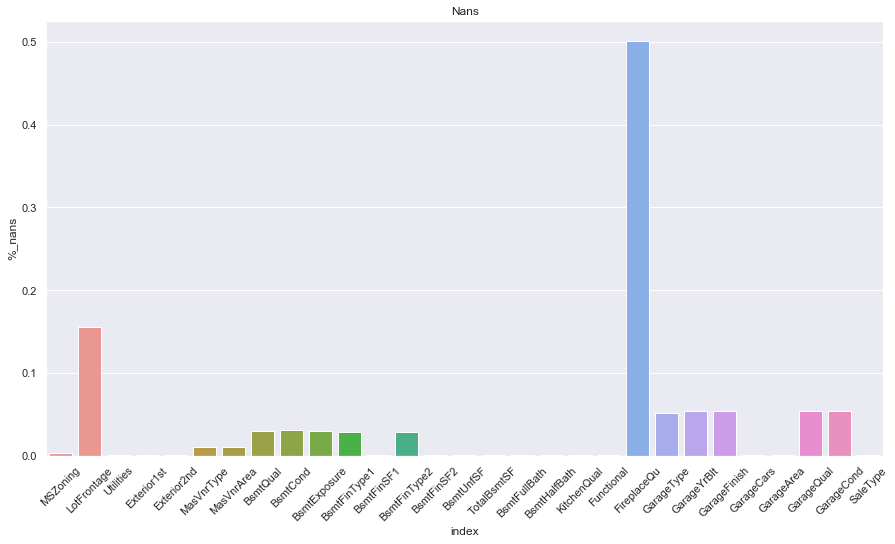

In [26]:
dt_test = drop_nans(dt_test, 0.51)
plt.figure(figsize=(15, 8))
sns.barplot(nans(dt_test)['index'], nans(dt_test)['%_nans'])
plt.xticks(rotation=45)
plt.title('Nans')
plt.show()

Según la descripción de las variables, LotFrontage:


>```
LotFrontage: Linear feet of street connected to property


Dado que es una variable numérica, los NaNs no han sido imputados necesariamente por una cuestión de criterios.

Vamos a ver cómo se relaciona la variable LotFrontage con el SalePrice:

In [27]:
dt_train['LotFrontage'].corr(dt_train['SalePrice'])

0.351799096570678

Veamos la distribución en el dataset de entrenamiento además de un scatterplot con la variable objetivo

In [28]:
pts = alt.selection(type="interval", encodings=["x"])
chrt = alt.Chart(dt_train).mark_bar().encode(x='LotFrontage',
                                       y='count(LotFrontage)',
                                       tooltip='count(LotFrontage)'
                                       ).transform_filter(pts).properties(width=600, height=450).interactive()

chrt2 = alt.Chart(dt_train).mark_point().encode(x='LotFrontage',
                                          y='SalePrice:Q',
                                          tooltip='SalePrice:Q'
                                          ).properties(width=600, height=450).add_selection(pts)
alt.hconcat(chrt, chrt2).display()

alt.HConcatChart(...)

Se aprecia que no existe una relación fuerte entre la variable objetivo y _LotFrontage_, además hay una serie de valores (con más de 300 uds) que no son parte significativa y distorsionan la muestra. Vamos a eliminarlas del dataset.

In [29]:
outlier = dt_train.LotFrontage.max()
out_index = list(dt_train.loc[dt_train['LotFrontage'] == outlier].index)
dt_train = dt_train.drop(out_index, axis=0)

Vamos a asignar el valor 0 a los NaNs faltantes de la variable _LotFrontage_, asumiendo que son casas sin acceso directo a la calle.

In [30]:
dt_train.LotFrontage.fillna(0, inplace=True)
dt_test.LotFrontage.fillna(0, inplace=True)

Ahora vamos a tratar la variable FireplaceQu;

>```
FireplaceQu: Fireplace quality
>
>       Ex	Excellent - Exceptional Masonry Fireplace
>       Gd	Good - Masonry Fireplace in main level
>       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
>       Fa	Fair - Prefabricated Fireplace in basement
>       Po	Poor - Ben Franklin Stove
>       NA	No Fireplace
>```

La cantidad de NaNs corresponde a que para las casas sin chimenea se ha dejado el valor en blanco.
Creamos una variable que resulta de multiplicar el número de chimeneas por un valor de 0 a 5:

In [32]:
for c, i in enumerate(list(dt_train.FireplaceQu.value_counts().index)):
    dt_train['FireplaceQu'] = dt_train['FireplaceQu'].apply(lambda x: c + 1 if x == i else x)

for c, i in enumerate(list(dt_test.FireplaceQu.value_counts().index)):
    dt_test['FireplaceQu'] = dt_test['FireplaceQu'].apply(lambda x: c + 1 if x == i else x)


Sustituimos los NaN's por el valor 0

In [35]:
dt_train['FireplaceQu'].fillna(0, inplace=True)
dt_test['FireplaceQu'].fillna(0, inplace=True)

Creamos la nueva variable como múltiplo de la calidad por el nº de hogueras, y eliminamos del dataset la columna original:

In [36]:
dt_train['FireplaceT'] = dt_train['Fireplaces'] * dt_train['FireplaceQu']
dt_test['FireplaceT'] = dt_test['Fireplaces'] * dt_test['FireplaceQu']

dt_train.drop(['Fireplaces', 'FireplaceQu'], axis=1, inplace=True)
dt_test.drop(['Fireplaces', 'FireplaceQu'], axis=1, inplace=True)

Vamos a ver ahora el porcentaje de NaN's actual para las variables restantes:

In [37]:
print('% NaNs en dt_train: ', len(nans_row_index(dt_train)) / len(dt_train))
print('% NaNs en dt_test: ', len(nans_row_index(dt_test)) / len(dt_test))

% NaNs en dt_train:  0.08367626886145405
% NaNs en dt_test:  0.09595613433858807


Para intentar eliminar cerca de un 10% de la información del dataset, vamos a intentar tratar individualmente los missings y reducir la cantidad de los mismos.
A través de la función nans_per_row vemos cuántos nans hay por fila:

```python
def nans_row_index(df):
    out_index = []
    for i in df.columns:
        mec = list(df[i][df[i].isnull()==True].index)
        for ii in mec:
            out_index.append(ii)

    out_index = list(dict.fromkeys(out_index))
    return out_index
```

In [44]:
print(nans_per_row(dt_test)['NaNs_Ammount'].value_counts().sort_index())
print(nans_per_row(dt_train)['NaNs_Ammount'].value_counts().sort_index())

1     13
2     14
4      1
5     97
6      2
7      5
10     7
11     1
Name: NaNs_Ammount, dtype: int64
1       3
2       8
5     104
10      7
Name: NaNs_Ammount, dtype: int64


La mayor parte de filas con nans tiene 5 variables, podemos apreciarlo más gráficamente con el siguiente gráfico de la librería missingno:

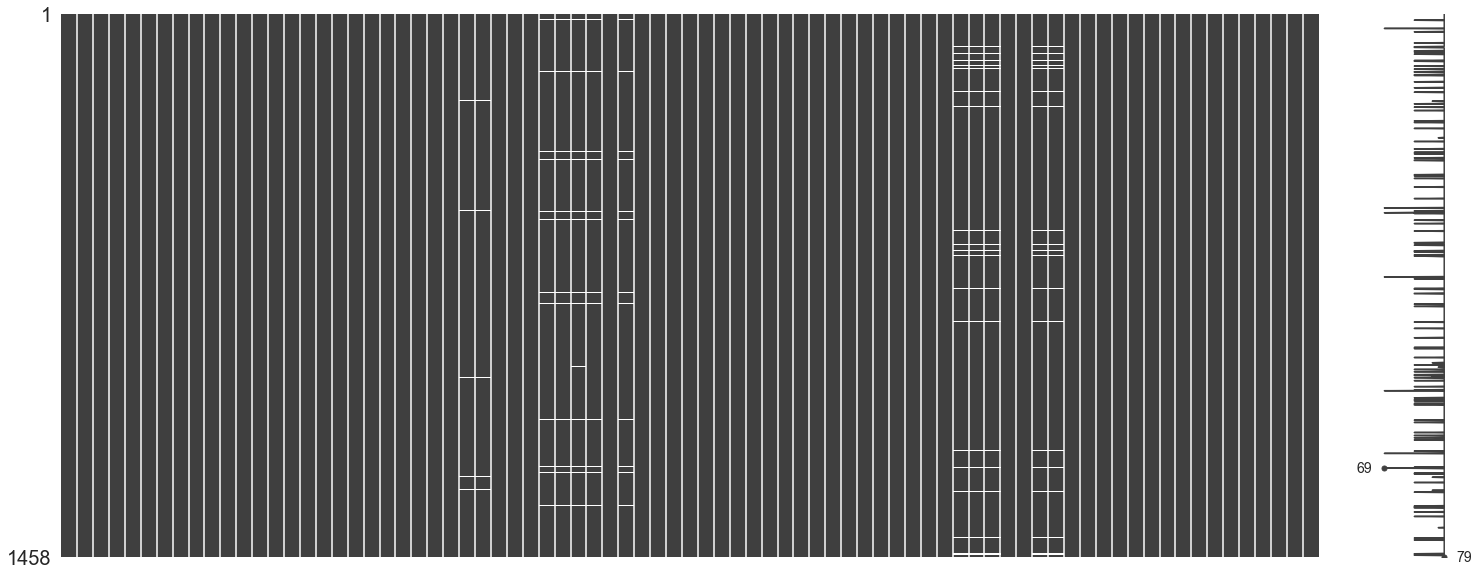

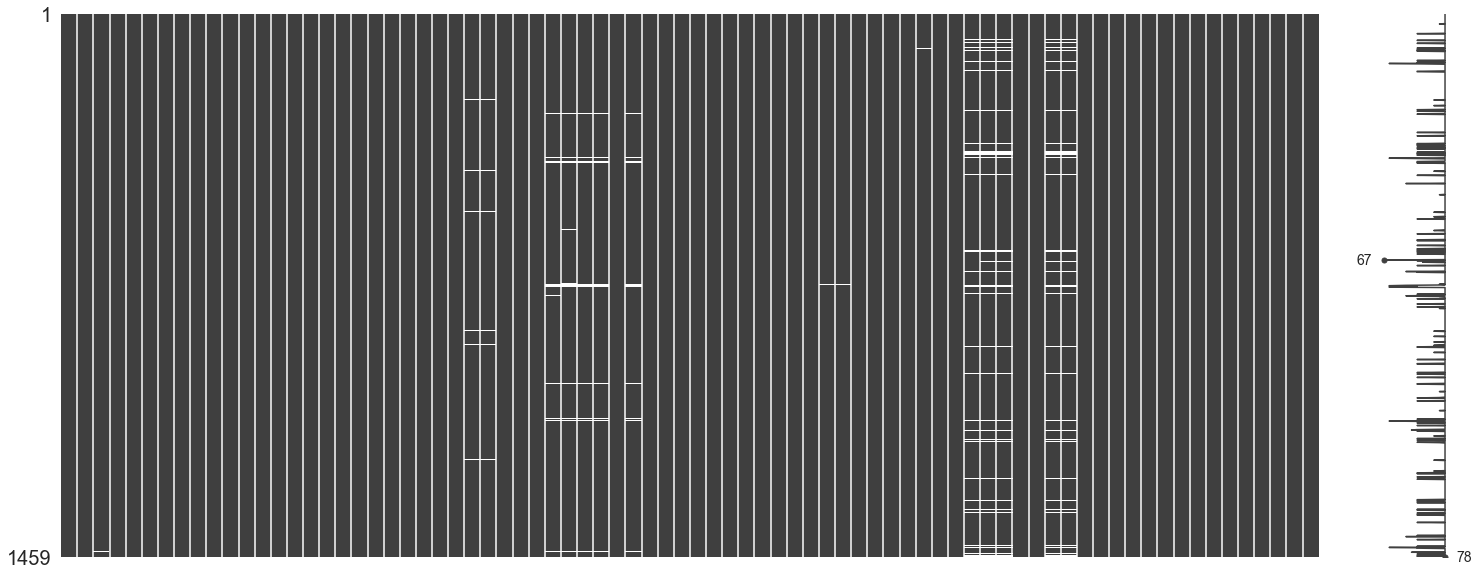

In [45]:
msno.matrix(dt_train)
msno.matrix(dt_test)

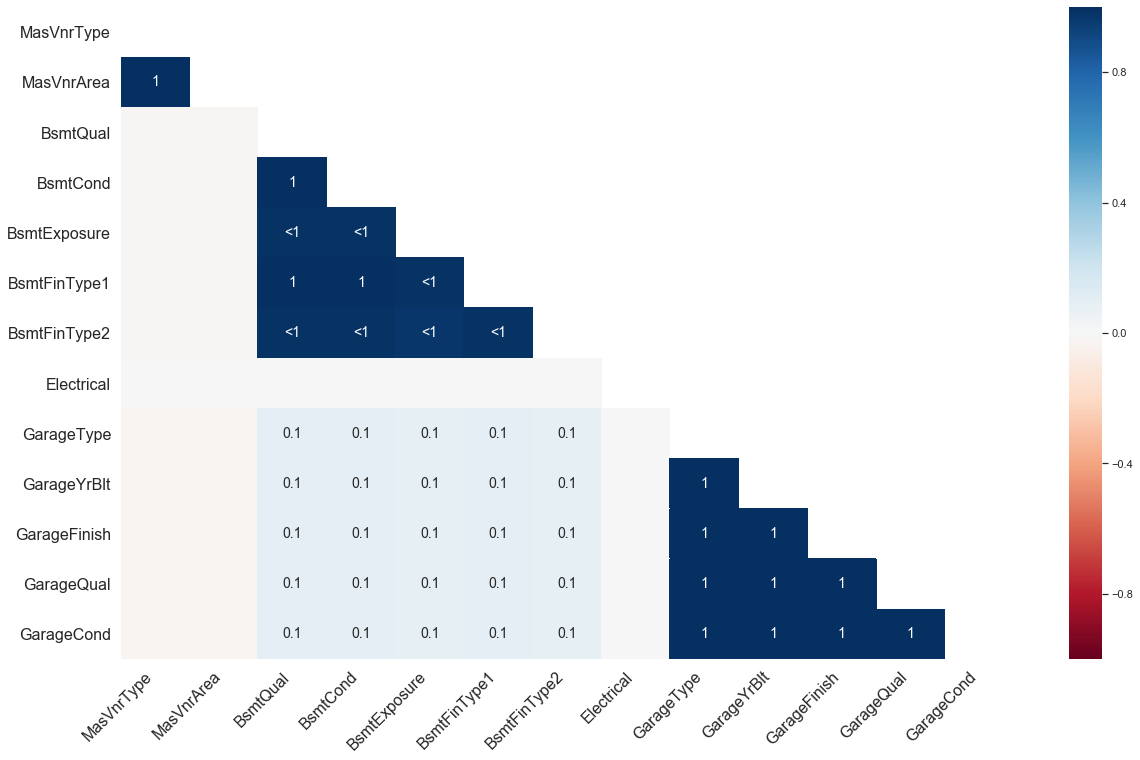

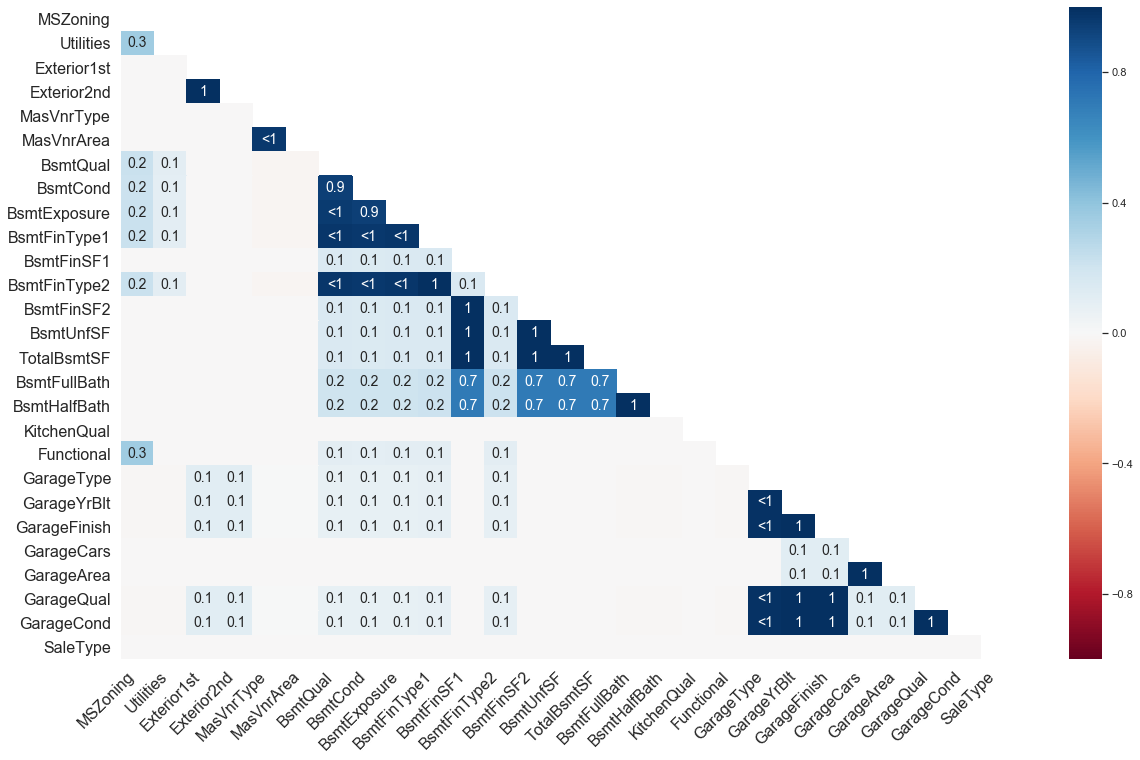

In [46]:
msno.heatmap(dt_train)
msno.heatmap(dt_test)

Todas la variables de atributos del garage o del sótano están correlacionadas.
Los nans corresponden a las casas sin garage o sin sótano, vamos a crear una categoría para ellas:

In [47]:
for i in dt_train.columns:
    if i.startswith('Bsmt') or i.startswith('Garage'):
        dt_train[i].fillna('NO', inplace=True)
        dt_test.fillna('NO', inplace=True)

Tras dar tratamiento, las variables MasVnrType y MasVnrArea tienen los mismos NaNs.
Son pocas filas y no tenemos forma de aproximar la información, las descartamos

In [48]:
dt_train.drop(list(nans_per_row(dt_train).index), axis=0, inplace=True)

In [52]:
print(dt_train.isnull().sum().value_counts())
print(len(dt_train))

0    79
dtype: int64
1449


In [53]:
print(dt_test.isnull().sum().value_counts())
print(len(dt_test))

0    78
dtype: int64
1459
